## 캐글 데이터셋 다운로드

In [ ]:
cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection

/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=5cd268980348e341ccb58ff1484c6062db6487400689018f1686568df16d5eb9
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = ' '   ## kaggle.json 파일에 있는 user name
os.environ['KAGGLE_KEY'] = ' '        ## kaggle.json 파일에 있는 key

In [ ]:
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings


In [ ]:
%cd dataset

!kaggle competitions download -c siim-covid19-detection

[Errno 2] No such file or directory: 'dataset'
/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/dataset
100% 83.2G/83.2G [16:27<00:00, 76.9MB/s]
100% 83.2G/83.2G [16:27<00:00, 90.4MB/s]


In [ ]:
!unzip -qq "/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/dataset/siim-covid19-detection.zip"

In [ ]:
import os

train_file_path = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/dataset/train')
test_file_path = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/dataset/test')

print(len(train_file_path))
print(len(test_file_path))

6054
1214


## yolov5 설치 및 Library 설치

In [ ]:
!nvidia-smi

Mon Dec 20 14:55:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 23.1 MB 1.3 MB/s 
     |████████████████████████████████| 2.1 MB 59.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.22.0
    Uninstalling tensorflow-io-gcs-filesystem-0.22.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.22.0


In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection

!git clone https://github.com/ultralytics/yolov5

/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection
Cloning into 'yolov5'...
remote: Enumerating objects: 10310, done.
remote: Total 10310 (delta 0), reused 0 (delta 0), pack-reused 10310
Receiving objects: 100% (10310/10310), 10.51 MiB | 11.41 MiB/s, done.
Resolving deltas: 100% (7127/7127), done.


In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5

!pip install -r requirements.txt

## DCM 파일 JPG 파일로 변환

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import ast
import yaml
import tensorflow_io as tfio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
siim_train_path = "/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/dataset/train"
siim_test_path = "/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/dataset/test"

IMAGE_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 25

In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection

os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test', exist_ok=True)

/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection


In [ ]:
def file_path(siim_train_path):
  paths = []
  for dirname, _, filenames in tqdm(os.walk(siim_train_path)):
    for filename in sorted(filenames):
        file_path = dirname + '/' + filename
        paths.append(file_path)
          
  return paths

In [ ]:
input_train_paths = file_path(siim_train_path)
input_test_paths = file_path(siim_test_path)

In [ ]:
print(len(input_train_paths))
print(len(input_test_paths))

6334
1263


In [ ]:
def resize_img_save(input_train_paths, split):
  ori_height = []
  ori_width = []
  filename = []
  
  for path in tqdm(input_train_paths):
    Dcm_read = tf.io.read_file(path)
    Dcm_scaled = tfio.image.decode_dicom_image(Dcm_read, scale='auto', on_error='lossy', dtype=tf.uint8)

    ori_height.append(Dcm_scaled.shape[1])
    ori_width.append(Dcm_scaled.shape[2])
    filename.append(path.split('/')[-1][:-4])
    
    array_dcm = Image.fromarray(np.squeeze(Dcm_scaled))

    resize_Dcm = array_dcm.resize((IMAGE_SIZE, IMAGE_SIZE))
    
    if path.split('/')[7] == split:
      resize_Dcm.save("/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/train/" + path.split('/')[-1][:-4] + ".jpg")
    else:
      resize_Dcm.save("/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test/" + path.split('/')[-1][:-4] + ".jpg")
      
  return (filename, ori_height, ori_width)

In [ ]:
(filename, ori_height, ori_width) = resize_img_save(input_train_paths, 'train')

In [ ]:
## DCM 원본 파일 이미지로 변환 후 파일명, 너비, 높이 값 데이터프레임 생성

train_dim_df = pd.DataFrame({'id':filename, 'ori_height':ori_height, 'ori_width':ori_width})

train_dim_df.to_csv('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/train_Dim.csv', mode='w')

In [ ]:
train_dim_df = pd.read_csv('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/train_Dim.csv', index_col=0)

In [ ]:
train_dim_df.head()

,id,ori_height,ori_width
0,3e78bf1aa418,2539,3050
1,ea85c81c2600,3006,3006
2,02037e3e6555,3480,4240
3,c113eeda4af3,3480,4248
4,8ae5a0f6c1fa,3480,4240


In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection

resize_train_path = "/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/train"
resize_test_path = "/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test"

resize_train_list = os.listdir(resize_train_path)
resize_test_list = os.listdir(resize_test_path)

print(len(resize_train_list))
print(len(resize_test_list))

/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection
6334
1263


## train_image_level.csv 수정

In [ ]:
resize_train_list = sorted(resize_train_list)

resize_train_list[:10]

['000a312787f2.jpg',
 '000c3a3f293f.jpg',
 '0012ff7358bc.jpg',
 '001398f4ff4f.jpg',
 '001bd15d1891.jpg',
 '0022227f5adf.jpg',
 '0023f02ae886.jpg',
 '002e9b2128d0.jpg',
 '00326161e51e.jpg',
 '0044e449aae1.jpg']

In [ ]:
## train_image_level

train_image_level  = pd.read_csv('./dataset/train_image_level.csv')
train_study_level = pd.read_csv('./dataset/train_study_level.csv')

pd.set_option('display.max_colwidth', 200)
train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


In [ ]:
## train_study_level

train_study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
train_study_level.rename(columns = {'Negative for Pneumonia':'Negative', 'Typical Appearance':'Typical', 
                                    'Indeterminate Appearance':'Indeterminate', 'Atypical Appearance':'Atypical'}, inplace = True)

train_study_level.head()

,id,Negative,Typical,Indeterminate,Atypical
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
## train_image_level 파일과 train_study_level 파일 병합

train_study_level['StudyInstanceUID'] = train_study_level['id'].apply(lambda x: x.replace('_study', ''))
df = train_image_level.merge(train_study_level, on='StudyInstanceUID')

df = df.drop(['id_y'], axis=1)
df.rename(columns = {'id_x':'id'}, inplace = True)

df.head()

,id,boxes,label,StudyInstanceUID,Negative,Typical,Indeterminate,Atypical
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,0,1,0,0


In [ ]:
df['id'] = df.apply(lambda ID: ID['id'].split('_')[0], axis=1)
df['path'] = df.apply(lambda PATH: resize_train_path+'/'+PATH['id']+'.jpg', axis=1)
df['img_label'] = df.apply(lambda LABEL: LABEL['label'].split(' ')[0], axis=1)

pd.set_option('display.max_colwidth', 200)
df.head()

,id,boxes,label,StudyInstanceUID,Negative,Typical,Indeterminate,Atypical,path,img_label
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/000a312787f2.jpg,opacity
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/000c3a3f293f.jpg,none
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/0012ff7358bc.jpg,opacity
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/001398f4ff4f.jpg,opacity
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/001bd15d1891.jpg,opacity


In [ ]:
## df와 train_dim_df 병합

df = df.merge(train_dim_df, on='id', how='left')

df.head()

,id,boxes,label,StudyInstanceUID,Negative,Typical,Indeterminate,Atypical,path,img_label,ori_height,ori_width
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/000a312787f2.jpg,opacity,3488,4256
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/000c3a3f293f.jpg,none,2320,2832
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/0012ff7358bc.jpg,opacity,2544,3056
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/001398f4ff4f.jpg,opacity,3520,4280
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/001bd15d1891.jpg,opacity,2800,3408


## BBOX 이미지 출력

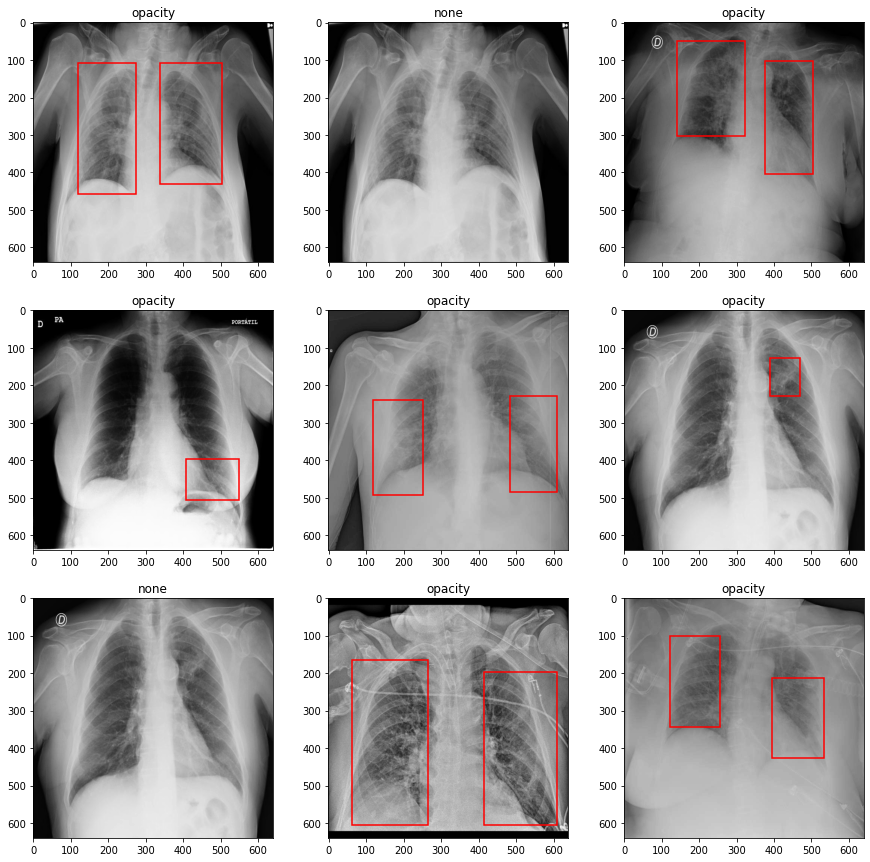

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
ax = ax.ravel()

for i in range(9):
  re_w = df.loc[i, 'ori_width'] / IMAGE_SIZE
  re_h = df.loc[i, 'ori_height'] / IMAGE_SIZE
  show_img_path = df.loc[i, 'path']

  if df.loc[i, 'boxes'] == df.loc[i, 'boxes']:
    boxes = ast.literal_eval(df.loc[i, 'boxes'])
    for box in boxes:
        im = Image.open(show_img_path)
        rect = patches.Rectangle((box['x']/re_w, box['y']/re_h),
                                  box['width']/re_w, box['height']/re_h,
                                  linewidth=1.5, edgecolor='r', fc='none')
        ax[i].add_patch(rect)
          
  ax[i].imshow(im, cmap='gray')
  ax[i].set_title(df.loc[i, 'img_label'])

## train, valid 나누기

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=2021)

In [ ]:
train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'

In [ ]:
df_all = pd.concat([train_df, valid_df]).reset_index(drop=True)
df_all.head()

,id,boxes,label,StudyInstanceUID,Negative,Typical,Indeterminate,Atypical,path,img_label,ori_height,ori_width,split
0,8eab0a525c09,"[{'x': 2710.06667, 'y': 1459.09996, 'width': 681.93335, 'height': 968.13342}, {'x': 840.93333, 'y': 1151.69991, 'width': 678.40002, 'height': 1275.53345}]",opacity 1 2710.06667 1459.09996 3392.0000200000004 2427.23338 opacity 1 840.93333 1151.69991 1519.3333499999999 2427.23336,6fc7c54a65f0,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/8eab0a525c09.jpg,opacity,3480,4240,train
1,3b1a6b2e295d,NaN,none 1 0 0 1 1,b0e4f3d07735,1,0,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/3b1a6b2e295d.jpg,none,2336,2836,train
2,479739d8c10d,"[{'x': 1312.11788, 'y': 708.86667, 'width': 368.725, 'height': 760.31667}, {'x': 531.79288, 'y': 574.525, 'width': 445.9, 'height': 723.15833}]",opacity 1 1312.11788 708.86667 1680.8428800000002 1469.18334 opacity 1 531.79288 574.525 977.69288 1297.6833299999998,0f47d2e5f328,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/479739d8c10d.jpg,opacity,1715,2056,train
3,f5af0ed4c2db,"[{'x': 457.71678, 'y': 29, 'width': 1542.8, 'height': 2151.8}, {'x': 2058.51661, 'y': 0, 'width': 1513.80018, 'height': 2343.2}]",opacity 1 457.71678 29 2000.51678 2180.8 opacity 1 2058.51661 0 3572.31679 2343.2,642d8346f37a,0,1,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/f5af0ed4c2db.jpg,opacity,3480,4240,train
4,fd4ee26e48d4,NaN,none 1 0 0 1 1,82ed58c1b0db,1,0,0,0,/content/drive/MyDrive/YOLOv5/SIIM COVID-19 Detection/resize_img/train/fd4ee26e48d4.jpg,none,3480,4248,train


In [ ]:
print(len(df_all[df_all['split']=='train']))
print(len(df_all[df_all['split']=='valid']))

5067
1267


In [ ]:
os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/valid', exist_ok=True)

os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/dataset/labels/valid', exist_ok=True)

os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/')

['images', 'labels']

In [ ]:
for SPLIT, PATH in tqdm(zip(df_all['split'], df_all['path'])):
  if SPLIT == 'train':
    shutil.copyfile(PATH, '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/train/'+PATH.split('/')[-1][:-4] + ".jpg")
  else:
    shutil.copyfile(PATH, '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/valid/'+PATH.split('/')[-1][:-4] + ".jpg")

6334it [09:37, 10.97it/s] 


In [ ]:
train_list = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/train')
val_list = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/valid')

print(len(train_list), train_list[:5])
print(len(val_list), val_list[:5])

5067 ['fa935d855d4e.jpg', 'f655da4793ba.jpg', '1e9fe71f89bf.jpg', '9a06de614828.jpg', '2b37bc3747ad.jpg']
1267 ['b4ec9b6e5da6.jpg', 'fba45bd0eb6f.jpg', 'cae7ad43780b.jpg', '12384ae3a66c.jpg', '262106ee8f85.jpg']


## yolo bbox로 포맷

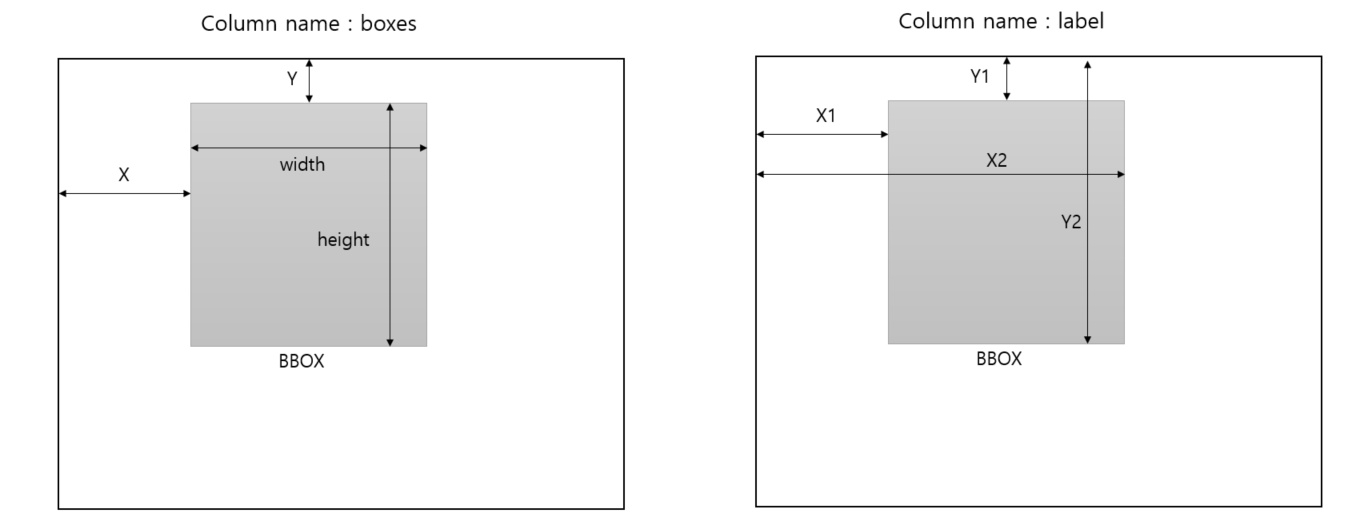

In [ ]:
def get_bbox(row):
  bbox = []
  bboxes = []
  for i, j in enumerate(row['label'].split(' ')):
    if (i % 6 == 0) | (i % 6 == 1):
      continue
    bbox.append(float(j))
    if i % 6 == 5:
      bboxes.append(bbox)
      bbox = []
  return bboxes

def scaled_bbox(row, IMAGE_SIZE, bboxes):
  x = IMAGE_SIZE / row['ori_width']
  y = IMAGE_SIZE / row['ori_height']
  
  scaled_bboxes = []
  for bbox in bboxes:
    xmin = int(np.round(bbox[0]*x, 4))
    ymin = int(np.round(bbox[1]*y, 4))
    xmax = int(np.round(bbox[2]*x, 4))
    ymax = int(np.round(bbox[3]*y, 4))
    scaled_bboxes.append([xmin, ymin, xmax, ymax])

  return scaled_bboxes

def resize_yolo_bbox(IMAGE_SIZE, scaled_bboxes):
  yolo_bboxes = []
  for bbox in scaled_bboxes:
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x_center = bbox[0] + (w/2)
    y_center = bbox[1] + (h/2)
    
    yolo_bboxes.append([x_center/IMAGE_SIZE, y_center/IMAGE_SIZE, w/IMAGE_SIZE, h/IMAGE_SIZE])
      
  return yolo_bboxes



def write_txt(row, IMAGE_SIZE, file_name):
  bboxes = get_bbox(row)
  scaled_bboxes = scaled_bbox(row, IMAGE_SIZE, bboxes)
  yolo_bboxes = resize_yolo_bbox(IMAGE_SIZE, scaled_bboxes)
  
  with open(file_name, 'w') as f:
    for bbox in yolo_bboxes:
        bbox = [1]+bbox              
        bbox = [str(i) for i in bbox]
        bbox = ' '.join(bbox)
        f.write(bbox)
        f.write('\n')

In [ ]:
for i in tqdm(range(len(df_all))):  
  row = df_all.loc[i]
  img_id = row['id']
  split = row['split']
  label = row['img_label']
  
  if split == 'train':
    file_name = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/train/{}.txt'.format(img_id)
  else:
    file_name = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/valid/{}.txt'.format(img_id)
    
  
  if label == 'opacity':
    write_txt(row, IMAGE_SIZE, file_name)

100%|██████████| 6334/6334 [00:26<00:00, 238.88it/s]


In [ ]:
train_label_path = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/train')
val_label_path = os.listdir('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/valid')

print(len(train_label_path), train_label_path[:5])
print(len(val_label_path), val_label_path[:5])

5067 ['eeef8cafe0b0.txt', '47643f20a15e.txt', '687af7523c99.txt', 'e4284637f3d1.txt', 'f87c7918e5a5.txt']
1267 ['2c41f0b77b68.txt', '786ec68934b4.txt', 'c5b4731a60bb.txt', 'd3c5da1c1b1b.txt', 'bb0435db5c6d.txt']


In [ ]:
for i in range(5):
  print(train_label_path[i])
  with open('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/labels/train/'+train_label_path[i], 'r') as f:
    print(f.readlines(), '\n')

eeef8cafe0b0.txt
['1 0.29765625 0.50234375 0.1609375 0.4046875\n', '1 0.84765625 0.60859375 0.1546875 0.3578125\n'] 

47643f20a15e.txt
['1 0.66953125 0.60546875 0.3140625 0.2734375\n'] 

687af7523c99.txt
['1 0.33046875 0.415625 0.2796875 0.803125\n', '1 0.80078125 0.42890625 0.2515625 0.6921875\n'] 

e4284637f3d1.txt
['1 0.42734375 0.31875 0.2609375 0.51875\n', '1 0.7875 0.34296875 0.2625 0.5609375\n'] 

f87c7918e5a5.txt
['1 0.30859375 0.51953125 0.2546875 0.5265625\n', '1 0.71328125 0.58984375 0.3078125 0.4609375\n'] 



In [ ]:
from glob import glob

train_image_list = glob('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/train/*.jpg')

valid_image_list = glob('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/images/valid/*.jpg')

print(len(train_image_list))
print(len(valid_image_list))

5067
1267


In [ ]:
with open('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/train.txt', 'w') as file:
  file.write('\n'.join(train_image_list)+'\n')

with open('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/valid.txt', 'w') as file:
  file.write('\n'.join(valid_image_list)+'\n')

## yaml 파일 수정

In [ ]:
data_yaml = dict(train = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/train.txt',
                 val = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/valid.txt',
                 nc = 2,
                 names = ['None', 'opacity'])

with open('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/yolo_dataset/data.yaml', 'w') as outfile:
  yaml.dump(data_yaml, outfile, default_flow_style=True)

In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/

os.listdir('./data/hyps')

/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5


['hyp.finetune.yaml',
 'hyp.finetune_objects365.yaml',
 'hyp.scratch-high.yaml',
 'hyp.scratch-low.yaml',
 'hyp.scratch-med.yaml',
 'hyp.scratch.yaml']

## Yolov5 Train

In [ ]:
!python train.py --img {IMAGE_SIZE} \
                  --batch {BATCH_SIZE} \
                  --epochs {EPOCHS} \
                  --data ./yolo_dataset/data.yaml \
                  --weights yolov5x.pt \
                  --cfg ./models/yolov5x.yaml \
                  --hyp ./data/hyps/hyp.finetune.yaml \
                  --name covid-detection \
                  --cache

train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./yolo_dataset/data.yaml, hyp=./data/hyps/hyp.finetune.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=covid-detection, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-12-20 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.0032, lrf=0.12, momentum=0.843, weight_decay=0.00036, warmup_epochs=2.0, warmup_momentum=0.5, warmup_bias_lr=0.05, box=0.0296, cls=0.243, cls_pw=0.631, obj=0.301, obj_pw=0.911, iou_t=0.2, anchor_t=2.91, fl_gamma=0.0, hsv_h=0.01

In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/runs/train/covid-detection
%ls

/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/runs/train/covid-detection
confusion_matrix.png                               results.png
events.out.tfevents.1640013461.272b126fbb64.851.0  train_batch0.jpg
F1_curve.png                                       train_batch1.jpg
hyp.yaml                                           train_batch2.jpg
labels_correlogram.jpg                             val_batch0_labels.jpg
labels.jpg                                         val_batch0_pred.jpg
opt.yaml                                           val_batch1_labels.jpg
P_curve.png                                        val_batch1_pred.jpg
PR_curve.png                                       val_batch2_labels.jpg
R_curve.png                                        val_batch2_pred.jpg
results.csv                                        weights/


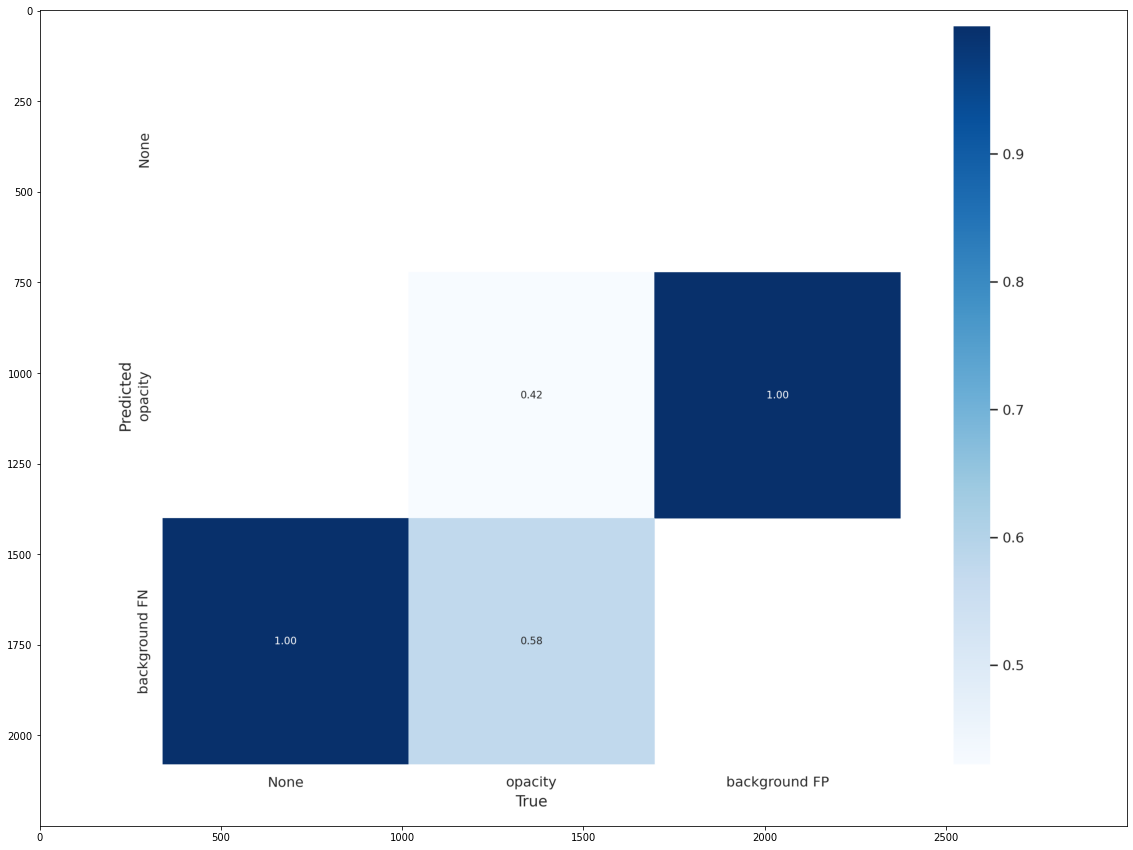

In [ ]:
plt.figure(figsize=(20, 15))
plt.imshow(plt.imread('./confusion_matrix.png'))

Text(0.5, 1.0, 'Pred')

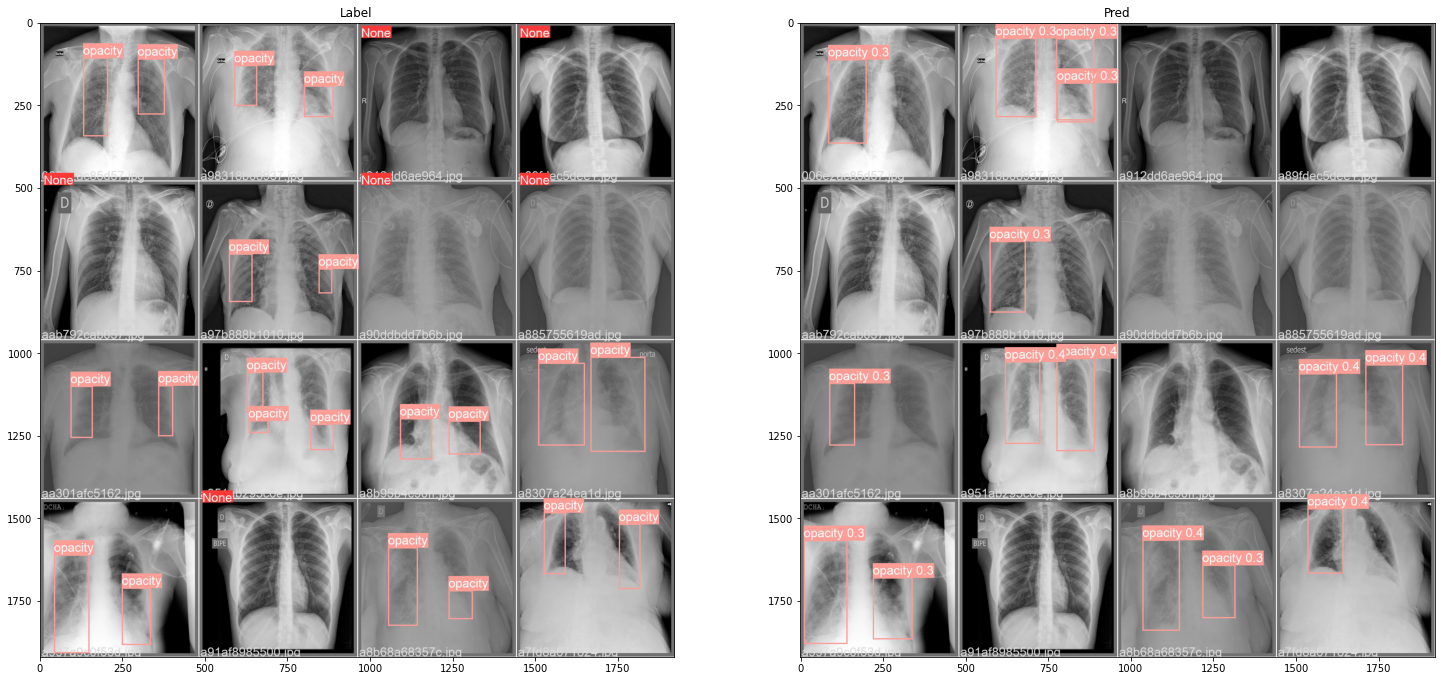

In [ ]:
plt.figure(figsize=(25, 20))

plt.subplot(1, 2, 1)
plt.imshow(plt.imread('./val_batch0_labels.jpg'))
plt.title('Label', fontsize = 12)

plt.subplot(1, 2, 2)
plt.imshow(plt.imread('./val_batch0_pred.jpg'))
plt.title('Pred', fontsize = 12)

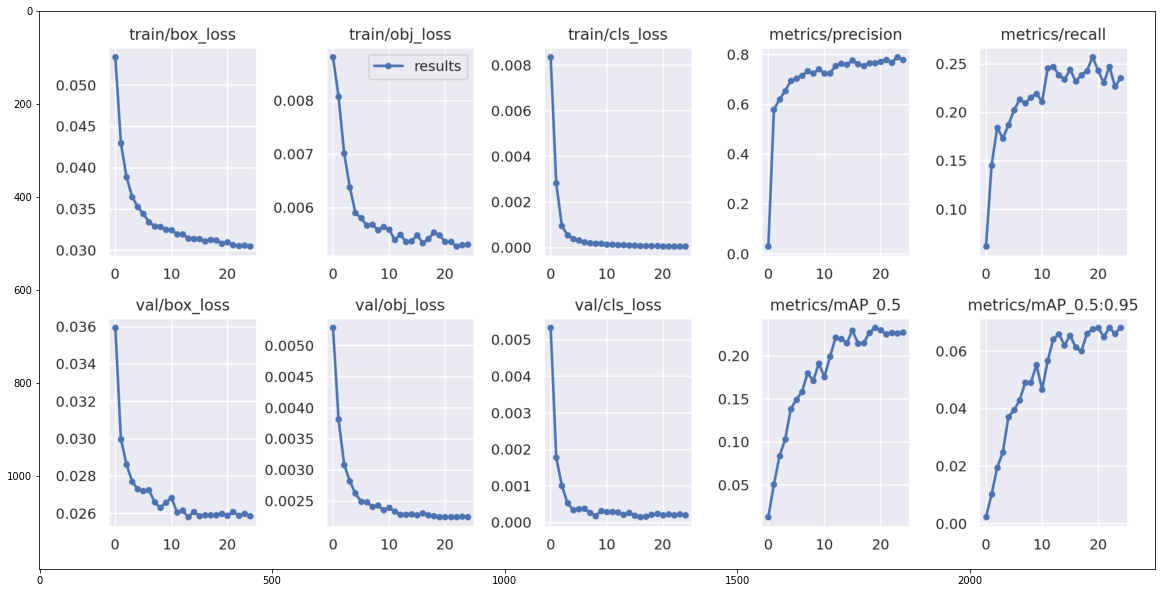

In [ ]:
plt.figure(figsize=(20,15))
plt.imshow(plt.imread('./results.png'))

## Test 이미지 예측

In [ ]:
(filename, ori_height, ori_width) = resize_img_save(input_test_paths, 'test')

100%|██████████| 1263/1263 [21:58<00:00,  1.04s/it]


In [ ]:
## DCM 원본 파일 이미지로 변환 후 파일명, 너비, 높이 값 데이터프레임 생성

test_dim_df = pd.DataFrame({'id':filename, 'ori_height':ori_height, 'ori_width':ori_width})

test_dim_df.to_csv('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test_Dim.csv', mode='w')

In [ ]:
model_weights = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/runs/train/covid-detection/weights/best.pt'
TEST_PATH = '/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test'

In [ ]:
%cd /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5 

!python detect.py --weights {model_weights} \
                  --source {TEST_PATH} \
                  --img {IMAGE_SIZE} \
                  --conf-thres 0.2 \
                  --iou-thres 0.5 \
                  --max-det 4 \
                  --save-txt \
                  --save-conf

/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5
detect: weights=['/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/runs/train/covid-detection/weights/best.pt'], source=/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.5, max_det=4, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-152-g26f0415 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86180143 parameters, 0 gradients, 204.0 GFLOPs
image 1/1263 /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test/0026720152f5.jpg: 640x640 Done. (0.039s)
image 2/1263 /content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/resize_img/test/

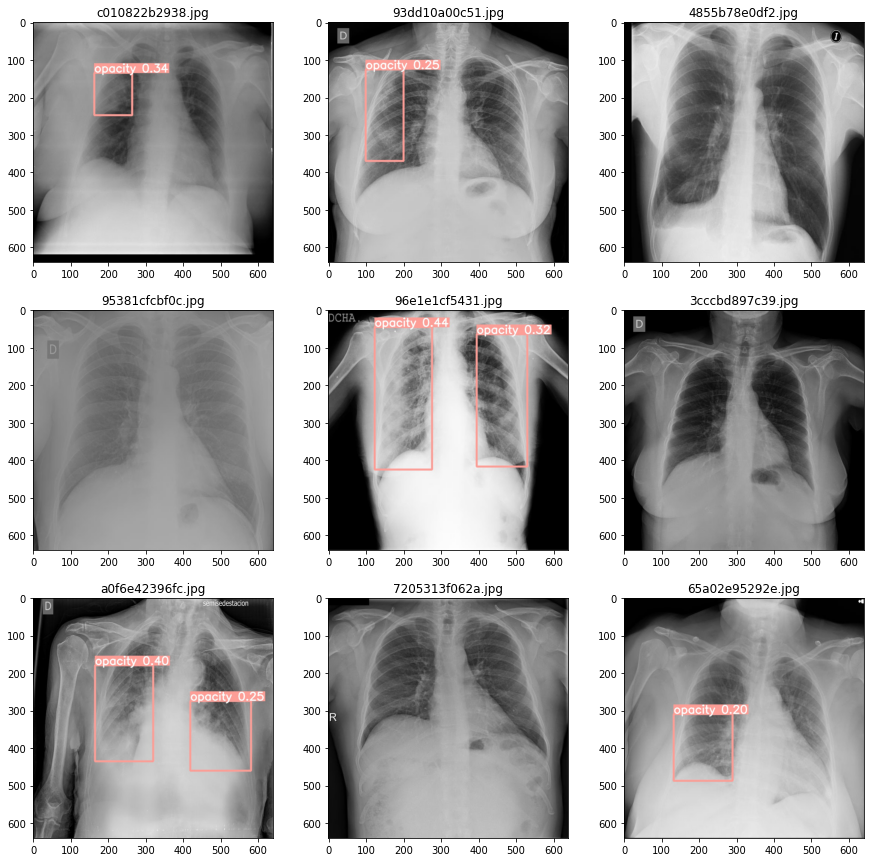

In [ ]:
from glob import glob
import random

test_pred_img = glob('/content/drive/MyDrive/YOLOv5/SIIM_COVID-19_Detection/yolov5/runs/detect/exp3/*.jpg')


fig, ax = plt.subplots(3,3, figsize=(15,15))
ax = ax.flatten()

for num, path in enumerate(random.sample(test_pred_img, 9)):
  im = Image.open(path)

  ax[num].imshow(im, cmap='gray')
  ax[num].set_title(path.split('/')[-1])